In [262]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('seaborn')

In [269]:
pd.set_option('max_columns', 24,'max_rows', 20) 
# pd.set_option('display.max_rows', None) 

In [270]:
#cp949 안돼서 UTF-8로 인코딩
df = pd.read_csv('Auction_master_train.csv',encoding ='UTF-8') 

In [271]:
plt.style.use('seaborn')
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

In [272]:
#데이터의 형태 확인
df.head()

,Auction_key,Auction_class,Bid_class,Claim_price,Appraisal_company,Appraisal_date,Auction_count,Auction_miscarriage_count,Total_land_gross_area,Total_land_real_area,Total_land_auction_area,Total_building_area,...,Total_floor,Current_floor,Specific,Share_auction_YorN,road_name,road_bunji1,road_bunji2,Close_date,Close_result,point.y,point.x,Hammer_price
0,2687,임의,개별,1766037301,정명감정,2017-07-26 00:00:00,2,1,12592.0,37.35,37.35,181.77,...,45,5,NaN,N,해운대해변로,30.0,NaN,2018-06-14 00:00:00,배당,35.162717,129.137048,760000000
1,2577,임의,일반,152946867,희감정,2016-09-12 00:00:00,2,1,42478.1,18.76,18.76,118.38,...,70,51,NaN,N,마린시티2로,33.0,NaN,2017-03-30 00:00:00,배당,35.156633,129.145068,971889999
2,2197,임의,개별,11326510,혜림감정,2016-11-22 00:00:00,3,2,149683.1,71.00,71.00,49.94,...,15,14,NaN,N,모라로110번길,88.0,NaN,2017-12-13 00:00:00,배당,35.184601,128.996765,93399999
3,2642,임의,일반,183581724,신라감정,2016-12-13 00:00:00,2,1,24405.0,32.98,32.98,84.91,...,20,11,NaN,N,황령대로319번가길,110.0,NaN,2017-12-27 00:00:00,배당,35.154180,129.089081,256899000
4,1958,강제,일반,45887671,나라감정,2016-03-07 00:00:00,2,1,774.0,45.18,45.18,84.96,...,7,7,NaN,N,오작로,51.0,NaN,2016-10-04 00:00:00,배당,35.099630,128.998874,158660000


# 0. 데이터 정보 파악

### 앗 부동산 데이터 너무너무 어렵다!

**[Data set]** Auction_master_train.csv 
: 서울/부산 지역의 낙찰가를 포함하여 경매 물건 아파트의 위치, 감정가, 경매 개시/종결일 등의 기본 정보(*최근2년)

**[Target_variable]** : Hammer Price // 낙찰가

**[Goal]** 아파트 경매가격 예측

### [Hammer_price(낙찰가)에 영향을 주는 변수 예상]

- Price : 금액
- Location : 위치
- Area & Floor : 면적과 층 수
- Period : 연식, 경매기간
- Miscarriage : 유찰 횟수
- Usage : 건물 용도
- etc : 지분경매여부....






# 1. 데이터 전처리

## 1-1. 결측값이 있는 모든 열 제거

In [273]:
#데이터 타입과 결측값이 있는 열 확인
# df.info()
df.isnull().sum(axis=0)

Auction_key          0
Auction_class        0
Bid_class            0
Claim_price          0
Appraisal_company    0
                    ..
Close_date           0
Close_result         0
point.y              0
point.x              0
Hammer_price         0
Length: 41, dtype: int64

In [274]:
print(df.shape) #원래 차원 확인
print(df.dropna(axis=1).shape) # 결측치 제거한 후 차원

(1933, 41)
(1933, 35)


## 1-2. 모든 연속형 변수 간 상관관계를 Heatmap을 통해 확인

In [275]:
# df.corr()
#데이터 프레임 안의 연속형 변수에 대한 상관관계를 출력함

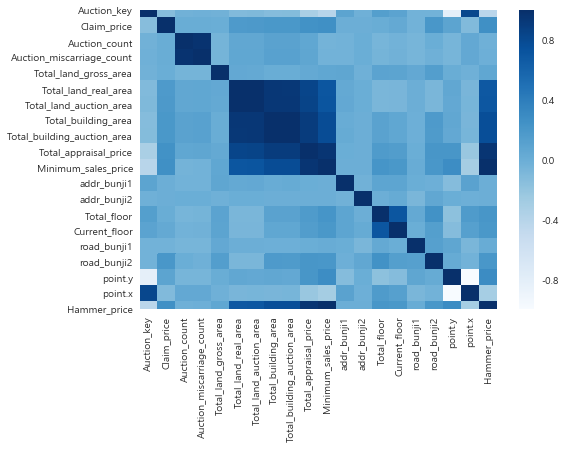

In [276]:
#상관계수 행렬을 바탕으로 온도지도 생성
sns.heatmap(df.corr(),cmap='Blues')
plt.show()

### 온도지도를 통해 알 수 있는 정보들

1.실면적, 경매면적, 건물면적 값이 클수록 감정가, 최저매각가격도 크다  *(면적과 가격은 당연히 비례)*

2.총 경매횟수가 높을수록 총 유찰횟수가 높다 *(경매가 많이 진행되었다 = 유찰이 자주 일어났다.)*

3.총 층수와 현재 층수도 높은 상관관계 *(건물의 총 층수가 높을수록 경매가 진행되는 층도 높을 수 밖에 없다)*

4.최저매각가격, 감정가가 클 수록 낙찰가가 높다. *(1번과 유사)*

## 1-3. 모든 연속형 변수의 분포를 Histogram으로 확인

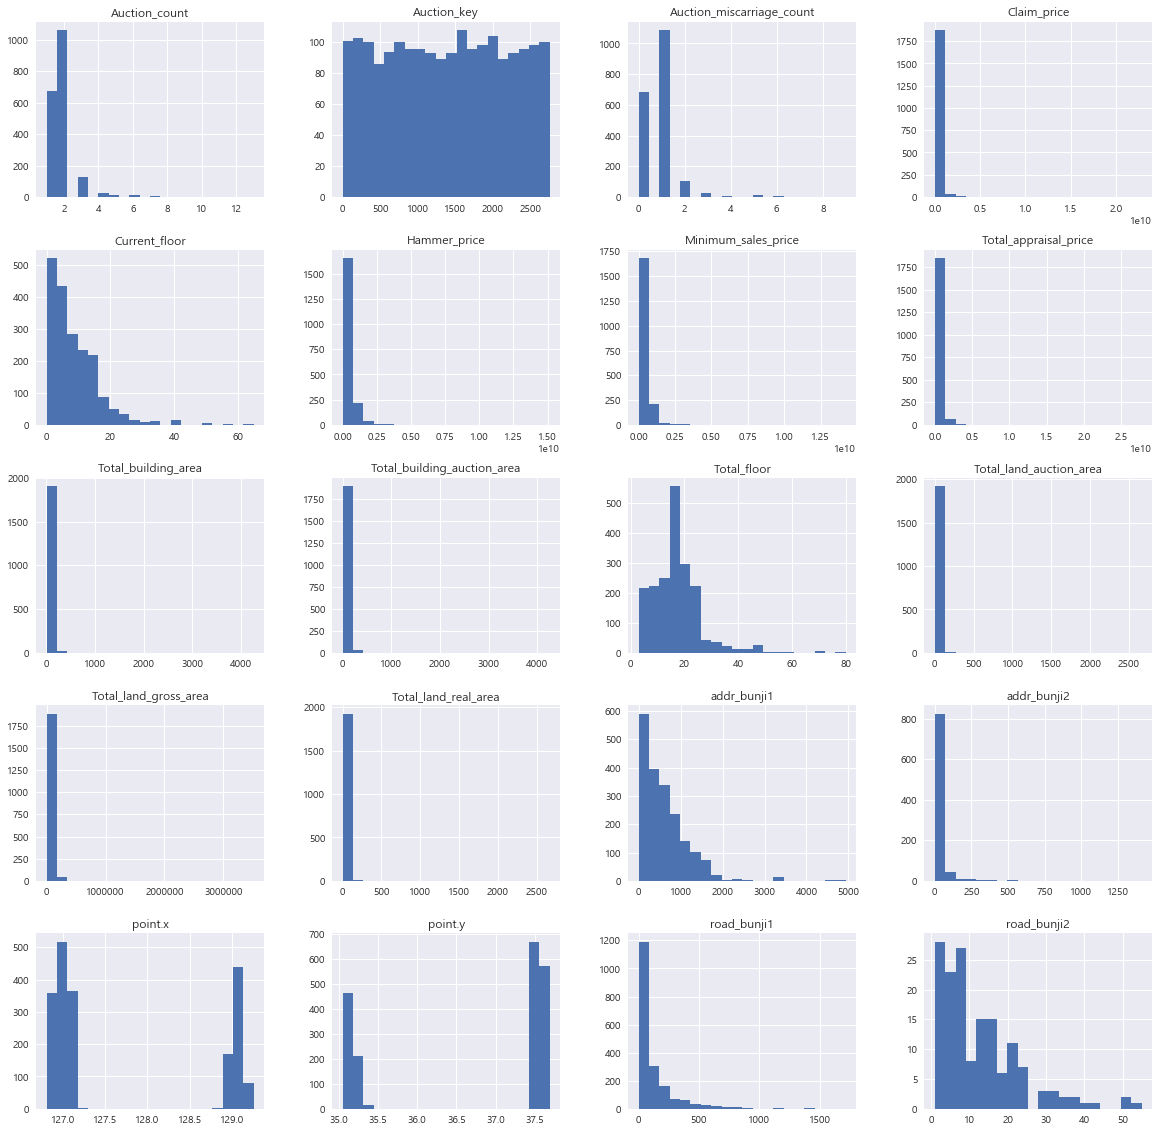

In [277]:
df.hist(bins=20,figsize=(20,20))
plt.show()

### Histogram에서 알 수 있는 정보  

1. Auction_count & Auction_miscarriage_count  
: 경매는 보통 첫 번째, 두 번째 안에 끝난다. 즉, 경매의 대부분이 유찰되지 않았거나 1번 유찰되었다는 뜻이다.   
  
  
2. Total_floor & Current_floor   
: 경매가 진행되는 아파트의 총 층수는 10\~20, 판매되는 층수는 0\~10정도가 가장 많음.


## 1-4. 유의미한 insight를 얻을 수 있는 시각화

### A. 전체 중 각 명목형 데이터가 차지하는 비율 (Pie Chart)

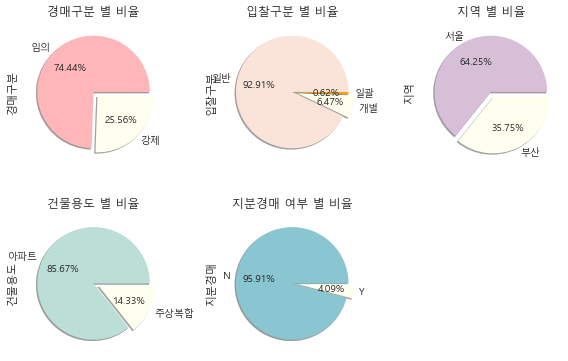

In [278]:
#1. 전체 경매건 중 경매구분 비율
plt.subplot(2,3,1)
Class_count = df['Auction_class'].value_counts()
Class_count.plot.pie(explode=[0,0.1], autopct = '%1.2f%%', shadow=True, colors=['#ffb6b9', 'ivory'])
plt.ylabel('경매구분')
plt.title('경매구분 별 비율')

#2.전체 경매건 중 입찰구분 비율
plt.subplot(2,3,2)
Bid_count = df['Bid_class'].value_counts()
Bid_count.plot.pie(explode=[0,0.1,0], autopct='%1.2f%%', shadow=True, colors=['#fae3d9', 'ivory', 'orange'])
plt.ylabel('입찰구분')
plt.title('입찰구분 별 비율')

#3.전체 경매건 중 시/도 비율
plt.subplot(2,3,3)
Do_count = df['addr_do'].value_counts()
Do_count.plot.pie(explode=[0,0.1],autopct='%1.2f%%',shadow=True, colors =['thistle', 'ivory']) 
plt.ylabel('지역')
plt.title('지역 별 비율')

#4.전체 경매건 중 건물의 용도 비율
plt.subplot(2,3,4)
Use_count = df['Apartment_usage'].value_counts()
Use_count.plot.pie(explode=[0,0.1],autopct='%1.2f%%',shadow=True, colors=['#bbded6', 'ivory']) 
plt.ylabel('건물용도')
plt.title('건물용도 별 비율')

#5.전체 경매건 중 지분경매 여부 비율
plt.subplot(2,3,5)
Share_count = df['Share_auction_YorN'].value_counts()
Share_count.plot.pie(explode=[0,0.1],autopct='%1.2f%%',shadow=True, colors=['#8ac6d1', 'ivory']) 
plt.ylabel('지분경매')
plt.title('지분경매 여부 별 비율')

plt.tight_layout()
plt.show()

### B. 경매건물면적 x 낙찰가 산점도 (Scatter Plot)

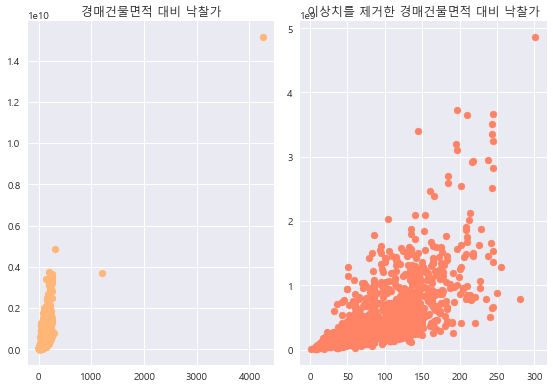

In [280]:
#기존 산점도 :: 이상치가 있어 분포 확인이 어렵다
plt.subplot(1,2,1)
plt.scatter(x='Total_building_auction_area',y='Hammer_price', data=df, color='#ffb677')
plt.title("경매건물면적 대비 낙찰가")

#이상치를 제거한 산점도 :: 면적이 증가할수록 낙찰가가 증가하고 있음을 확인할 수 있다.
plt.subplot(1,2,2)
df2 = df.query('Total_building_auction_area<1000 & Hammer_price < 5000000000') #낙찰가 50억 미만
plt.scatter(x='Total_building_auction_area',y='Hammer_price', data=df2, color='#ff8364')
plt.title("이상치를 제거한 경매건물면적 대비 낙찰가")

plt.tight_layout()
plt.show()

### C. 지역별(서울/부산) 경매건물면적 x 낙찰가 비교

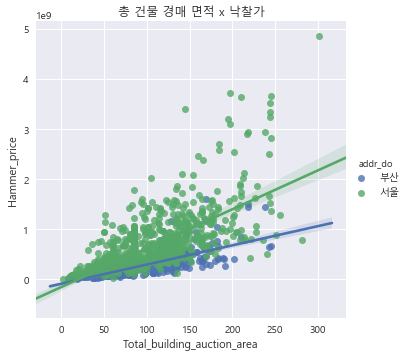

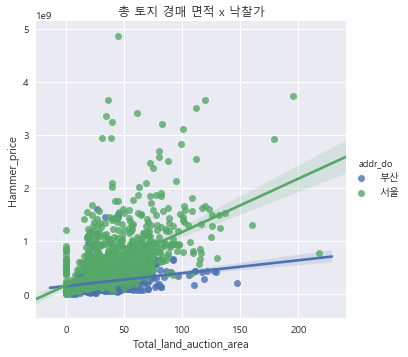

In [281]:
# Subplot 이용해서 나란히 옆에 두고 싶었는데 얘는 잘 안 되네요 
# 색도 바꾸어 보고 싶었는데 자꾸 서울과 부산이 같이 바뀌어요 증말~!

sns.lmplot(x='Total_building_auction_area',y='Hammer_price',hue='addr_do',data=df2)
plt.title('총 건물 경매 면적 x 낙찰가')
plt.show()

sns.lmplot(x='Total_land_auction_area',y='Hammer_price',hue='addr_do',data=df2)
plt.title('총 토지 경매 면적 x 낙찰가')
plt.show()

# [해석] 경매면적 대비 낙찰가의 증가량은 부산보다 서울이 높다!

### D. 서울/부산의 유찰횟수 비율 비교 (KDE plot)

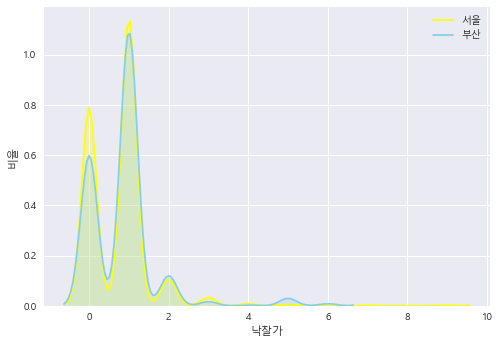

In [283]:
sns.kdeplot(df.query('addr_do == "서울"')['Auction_miscarriage_count'], color = "yellow",shade= True, label="서울")
sns.kdeplot(df.query('addr_do == "부산"')['Auction_miscarriage_count'], color = "skyblue",shade= True, label="부산")
plt.xlabel("낙찰가")
plt.ylabel("비율")
plt.show()

# [해석1] : 유찰이 없었던 비율은 서울이 더 높다.
# [해석2] : 허나 유찰이 7회 이상인 장기경매건도 서울이 더 높다 (부산은 상대적으로 무난하네요)

### E. 지분경매 여부에 따른 낙찰가 비율

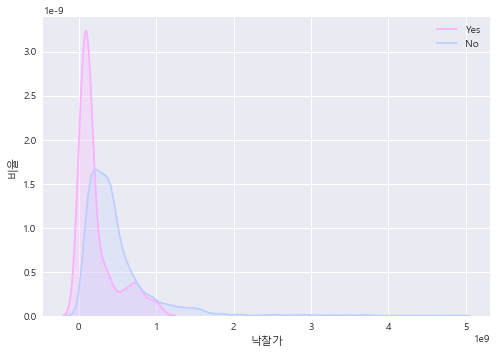

In [286]:
# 위에서 이상치 제거를 위해 처리한 df2 데이터 이용
sns.kdeplot(df2.query('Share_auction_YorN == "Y"')['Hammer_price'], color = "#faafff",shade= True, label="Yes")
sns.kdeplot(df2.query('Share_auction_YorN == "N"')['Hammer_price'], color = "#bbcfff",shade= True, label="No")
plt.xlabel("낙찰가")
plt.ylabel("비율")
plt.show()

#[해석] : 지분경매(Yes) 데이터의 낙찰가가 현저히 더 낮게 분포 되어 있음.

# 5. Feature Engineering

### 낙찰가에 영향을 주는 변수

- Price : 금액
- Location : 위치
- Area & Floor : 면적과 층 수
- Period : 연식, 경매기간
- Miscarriage : 유찰 횟수
- Usage : 건물 용도
- etc : 지분경매여부....


### 5-1. 유찰횟수와 최저매각가격    

[참고자료] (http://land.hankyung.com/board/view.php?id=_column_116_1&no=88)

> 유찰된 물건은 약 한달 후에 다시 경매에 부쳐지는데 이 때의 경매가격은 종전 경매가격에서 **20% 또는 30%가 저감된 가격이 최저매각가격**이 된다.

#### 즉, 유찰횟수가 많아질수록 낙찰가는 최저매각가격에 가까워질 것이다  

In [288]:
# 이를 위해 낙찰가에서 최저매각가격을 뺀 새로운 변수 생성 
# 편의상 '낙찰이익가'라고 명명

df['Hammer-Minimum'] = df['Hammer_price']-df['Minimum_sales_price']

#이 값이 크다 : 최저매각가격보다 값이 많이 쳐짐. 경매신청자에게 더 이득
#이 값이 작다 : 최저매각가격 정도로 판매되었으므로 경매신청자는 슬픔

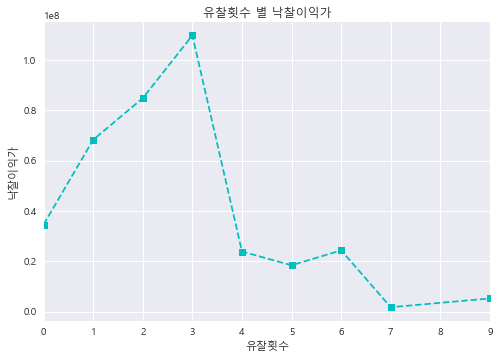

In [290]:
# 유찰횟수 별 낙찰이익가 
g = df.groupby(['Auction_miscarriage_count']).mean()['Hammer-Minimum']
g.plot(x=g.index, y=g.values, color="c", marker="s", style="--")
plt.title("유찰횟수 별 낙찰이익가")
plt.xlabel("유찰횟수")
plt.ylabel("낙찰이익가")
plt.show()

#### 해석  
- 유찰횟수 4이후로 최저매각가에 가까운 가격으로 낙찰이 이루어진 건 맞으나  
- 의외로 유찰횟수 3에서 낙찰이익가의 평균이 가장 높았음. 
- 무조건 유찰횟수가 적을수록 낙찰이익이 많다는 것은 아닌가보다

### 5-2.낙찰가를 경매면적으로 나눈 면적대비낙찰가 변수 생성

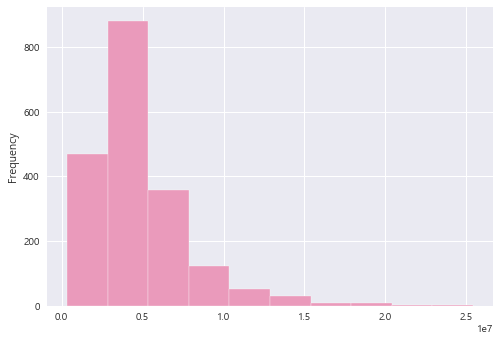

In [291]:
#Area_Hammer(면적대비낙찰가) : 낙찰가 / 총경매건물면적
df['Area_Hammer'] = df['Hammer_price'] / df['Total_building_auction_area']

#히스토그램으로 분포 확인
df['Area_Hammer'].plot.hist(bins=10,color='#ea9abb',edgecolor='white')
plt.show()

#[해석] : 낙찰가에 가장 큰 영향을 주는 면적변수로 나누어줌으로써 면적을 제외한 다른 변수의 영향을 확인할 수 있음.


### 5-3. 경매기간이 낙찰가에 미치는 영향

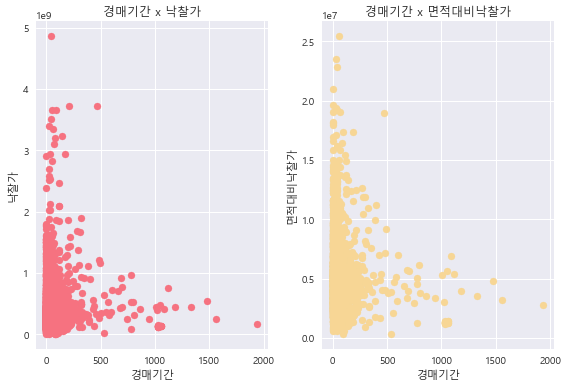

In [67]:
#파이썬 날짜 데이터로 변환
df['First_auction_date_dt'] = pd.to_datetime(df['First_auction_date'])
df['Final_auction_date_dt'] = pd.to_datetime(df['Final_auction_date'])

#경매기간을 나타내는 변수 Auction_period 생성
df['Auction_period'] = (df['Final_auction_date_dt'] - df['First_auction_date_dt']).dt.days
df['Auction_period']

#경매기간 별 낙찰가 plot 생성
df3 = df.query('Hammer_price < 5000000000') #낙찰가 50억 미만

#Hammer_price 투입
plt.subplot(1,2,1)
plt.scatter(x='Auction_period',y='Hammer_price', data=df3, color="#f67280")
plt.title("경매기간 x 낙찰가")
plt.xlabel("경매기간")
plt.ylabel("낙찰가")

#Area_Hammer 투입 (면적대비낙찰가)
plt.subplot(1,2,2)
plt.scatter(x='Auction_period',y='Area_Hammer', data=df3, color="#f7d695")
plt.title("경매기간 x 면적대비낙찰가")
plt.xlabel("경매기간")
plt.ylabel("면적대비낙찰가")

plt.tight_layout()
plt.show()

#[해석] : 경매기간이 길수록 낙찰가는 낮은 경향
# 면적대비낙찰가도 큰 차이는 없음.

### 5-4. 연식에 따른 낙찰가

In [68]:
#보존등기일(Preserve_regist_date) 변수는 '1111-11-11 00:00:00' 이라는 결측값 존재
#때문에 다른 변수들처럼 to-datetime으로 처리가 불가했음 (bound 초과)

#min()을 이용해 miss_date에 '1111-11-11 00:00:00' 데이터를 입력받음.
miss_date = df['Preserve_regist_date'].min()

#replace로 해당 데이터 대치, inplace를 이용해 데이터에 즉시 반영
df['Preserve_regist_date'].replace(miss_date, "2020-01-01 00:00:00", inplace=True)

#이후 max값을 찍어본 결과 '2020-01-01 00:00:00' 출력 --> 정상적으로 처리
df['Preserve_regist_date'].max()

#to_datetime을 이용해 변환, 새 변수에 저장
df['Preserve_regist_date_dt'] = pd.to_datetime(df['Preserve_regist_date'])

In [69]:
df['Est_Period'] = (df['First_auction_date_dt'] - df['Preserve_regist_date_dt']).dt.days
# df['Est_Period']
# 음수 값을 갖는 데이터는 위에서 전처리 한 데이터로 분석에서 제외

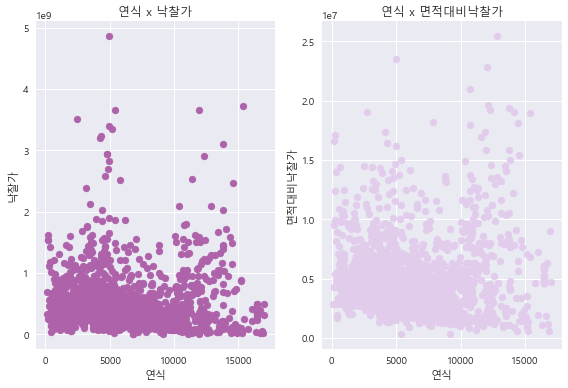

In [70]:
#낙찰가 50억 미만 & Est_Period가 이상값이 아닌 경우만
df4 = df.query('Hammer_price < 5000000000 & Est_Period > 0') 

#Hammer_price 투입
plt.subplot(1,2,1)
plt.scatter(x='Est_Period',y='Hammer_price', data=df4, color="#ad62aa")
plt.title("연식 x 낙찰가")
plt.xlabel("연식")
plt.ylabel("낙찰가")

#Area_Hammer 투입 (면적대비낙찰가)
plt.subplot(1,2,2)
plt.scatter(x='Est_Period',y='Area_Hammer', data=df4, color="#e1ccec")
plt.title("연식 x 면적대비낙찰가")
plt.xlabel("연식")
plt.ylabel("면적대비낙찰가")

plt.tight_layout()
plt.show()
#[해석] : 연식에 따른 낙찰가는 뚜렷한 특징이 없어보임
#[해석] : 연식에 따른 면적대비 낙찰가는 낮아지는 경향을 보임

### 5-5. 아파트 층 수와 낙찰가 간 관계

In [159]:
def floor_categorize(floor):
    if floor < 6: 
        return "저층"
    elif floor < 10:
        return "중간층"
    elif floor < 20:
        return "고층"
    elif floor < 30:
        return "초고층"
    else:
        return "초초고층"

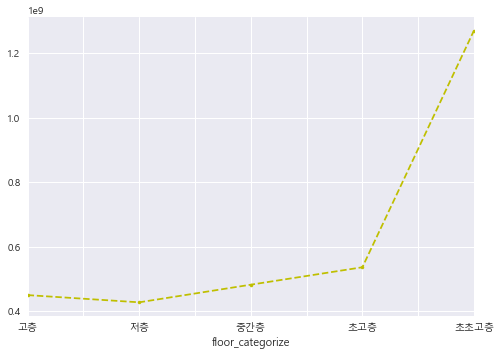

In [160]:
#새로운 변수 floor categorize 생성
df['floor_categorize'] = df['Current_floor'].apply(floor_categorize)

#아파트 층 수와 낙찰가 간 꺾은선 그래프 생성
g2 = df.groupby('floor_categorize').mean()['Hammer_price']
g2.plot(x=g2.index, y=g2.values, color="y", marker=".", style="--")
plt.show()

#[해석] : 고층으로 갈수록 낙찰가가 크다.

### 5-6. 분기별 낙찰가 차이

[]

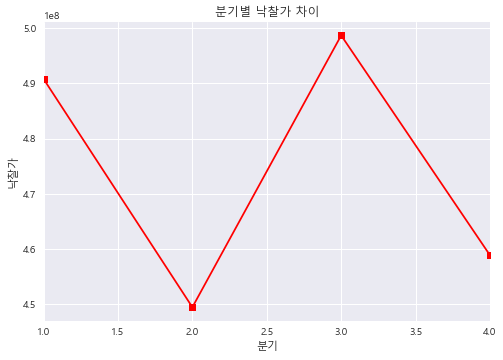

In [97]:
#분기 정보를 저장하는 변수 생성
df['Final_auction_date_dt_quarter'] = df['Final_auction_date_dt'].dt.quarter

#분기별 낙찰가를 나타내는 꺾은선 그래프 생성
g3 = df.groupby('Final_auction_date_dt_quarter').mean()['Hammer_price']
g3.plot(x=g3.index, y=g3.values, color="r", marker="s", style="-")
plt.title("분기별 낙찰가 차이")
plt.xlabel("분기")
plt.ylabel("낙찰가")

plt.plot()

#[해석] : 3분기에 낙찰가 평균이 가장 높았으며 2분기에 가장 낮았음.
#[해석] : 분기가 낙찰가에 영향을 미친다고 생각할 수 있다.

### 5-7. 도로명 주소를 통한 분류로 알아보는 낙찰가 차이
[링크] https://brunch.co.kr/@seouledu/257
> 도로명 주소 중 '대로', '로', '길'에 따라 주거지 주변 교통상황이 다름.
1. 대로 : 왕복 8차선 이상  
2. 로 : 왕복 2~7차선  
3. 길 : '로'보다 좁은 길  <

따라서 도로명 주소를 통한 분류에 따른 낙찰가 평균은
'로'가 가장 높고, 그 다음 대로, 길 순서일 것이라 추측



In [141]:
def road_categorize(road):
    if road=="대로":
        return "대로"
    elif road[-1]=="로":
        return "로"
    else:
        return "길"

#슬라이싱 통해 맨 뒤 두 글자만 추출
df['road_name_end2'] = df['road_name'].str[-2:]

#함수를 적용하여 road_name을 '대로', '로', '길'로 나눔
df['road_categorize'] = df['road_name_end2'].apply(road_categorize)

#처리가 잘 되었나 비교해보기
# df[['road_name', 'road_name_end2', 'road_categorize']]


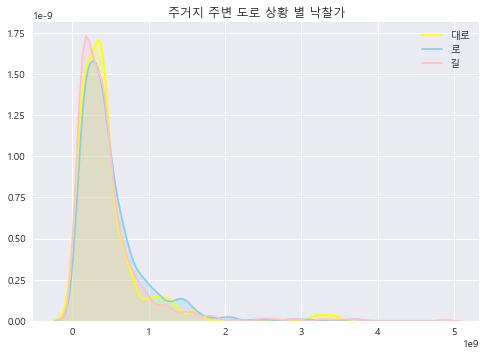

In [155]:
sns.kdeplot(df.query('road_categorize == "대로" & Hammer_price < 5000000000')['Hammer_price'], color = "yellow",shade= True, label="대로")
sns.kdeplot(df.query('road_categorize == "로" & Hammer_price < 5000000000')['Hammer_price'], color = "skyblue",shade= True, label="로")
sns.kdeplot(df.query('road_categorize == "길" & Hammer_price < 5000000000')['Hammer_price'], color = "pink",shade= True, label="길")
plt.title("주거지 주변 도로 상황 별 낙찰가")
plt.show()

#[해석] : 10억~20억(1~2) 구간을 살펴보면 로>대로>길 순서인 것을 볼 수 있다.
#따라서 낙찰가는 주거지 근처 도로 상황의 영향을 받는다고 할 수 있다.

### 5-8. 아파트 평수에 따른 경매 빈도 비교

[링크] (https://m.post.naver.com/viewer/postView.nhn?volumeNo=6586316&memberNo=34662358)

> 84제곱미터가 넘는 아파트의 경우는 건물에 대한 부가세를 지급해야 함.

그렇다면 아파트 평수에 따른 낙찰가가 84제곱미터 전 후로 유의미한 차이가 날까?


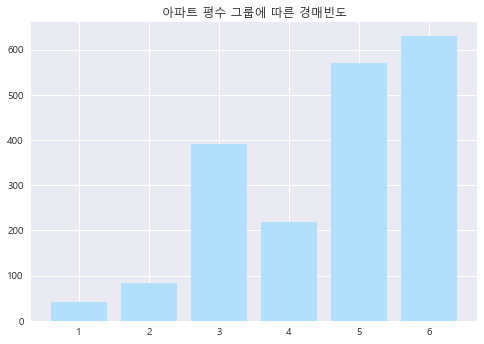

In [218]:
#Total_building_auction_area(총건물경매면적)Group화
def building_categorize(b):
    if b < 20:
        return 1 #20미만
    elif b < 40:
        return 2 #20이상 40미만
    elif b < 60:
        return 3 #40이상 60미만
    elif b < 80:
        return 4 #60이상 80미만
    elif b < 100:
        return 5 #80이상 100미만
    else:
        return 6 #100이상

#아파트 평수를 그룹화 한 새로운 변수 생성 
df['Total_building_group'] = df['Total_building_auction_area'].apply(building_categorize)

#아파트 평수 그룹에 따른 경매 빈도 비교
build = df['Total_building_group'].value_counts()
build = build.sort_index()
plt.bar(build.index,build, color=['#b2dffb'])
plt.title("아파트 평수 그룹에 따른 경매빈도")
plt.show()

#주목해 보아야 할 구간은 3~5 즉 40이상 100미만 부분! 
#놀랍게도 면적 규모가 클수록 경매건수도 증가하는 듯 하다가
#60~80구간에서 건수가 상대적으로 적은 모습을 볼 수 있다.

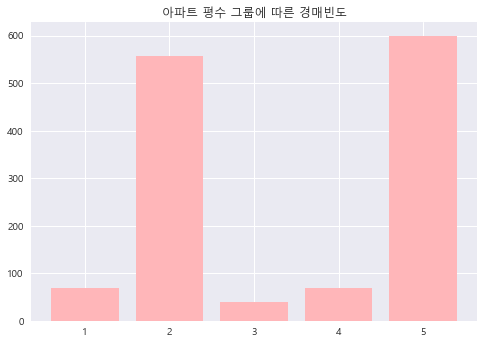

In [226]:
#3~5 구간을 세분화 시켜보자
def building_categorize_detail(b):
    if b < 70:
        return 0 #70미만
    elif b < 75:
        return 1 #70이상 75미만
    elif b < 85:
        return 2 #80이상 85미만
    elif b < 95:
        return 3 #90이상 95미만
    elif b < 105:
        return 4 #100이상 105미만
    else:
        return 5 #105이상
    
#아파트 평수를 그룹화 한 새로운 변수 생성 
df['Total_building_group_detail'] = df['Total_building_auction_area'].apply(building_categorize_detail)

#아파트 평수 그룹에 따른 경매 빈도 비교 
#query를 통해 70이상 데이터만 포함
build2 = df.query('Total_building_group_detail != 0')['Total_building_group_detail'].value_counts()
build2 = build2.sort_index()
plt.bar(build2.index,build2, color=['#ffb6b9'])
plt.title("아파트 평수 그룹에 따른 경매빈도")
plt.show()

#[해석] 3,4구간 (90~105)에서는 무슨 일이 일어나는가?
# 내 생각에는 부가세를 내지 않기 위해 이왕 살거면 85미만인 아파트를 구매하고 
# 이왕 크게 살거면 아예 크게 사는 것 같다고 생각
# 따라서 부가세에 의해 아파트 면적 또한 경매에 영향을 주는 변수라고 할 수 있다

### 5-9. 아파트 평수에 따른 낙찰가 비교

In [293]:
#경매빈도가 아닌 낙찰가는 어떻게 변하는가 확인해보자
#위에서 정의한 변수를 그대로 활용한다.
g4 = df.groupby('Total_building_group').mean()['Hammer_price']
g5 = df.query('Total_building_group_detail != 0').groupby('Total_building_group_detail').mean()['Hammer_price']

plt.subplot(1,2,1)
g4.plot(x=g4.index, y=g4.values, color="c", marker="s", style="--")
#[해석] 80이상 100미만(5)를 기준으로 확 낙찰가가 높아지는 모습

plt.subplot(1,2,2)
g5.plot(x=g5.index, y=g5.values, color="r", marker="s", style="--")

plt.tight_layout()
plt.show()
#[해석] 2~3사이, 부가세의 유무가 결정되는 구간에서 가파른 증가를 보임


KeyError: 'Total_building_group'

### 5-10. 낙찰가에 따른 빈도 계산
[링크] http://realty.chosun.com/site/data/html_dir/2019/07/16/2019071602686.html
> 대형 평수의 6억 이상 아파트의 경우 취득세가 증가
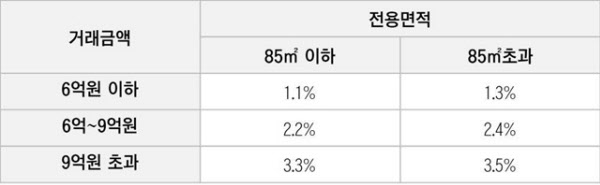 [이미지 참고]

그렇다면 취득세 인상의 기준이 되는 6억, 9억 바운더리에서의 경매건수가  전체에 비해 적지 않을까 생각해보았음.


In [294]:
#Hammer_price 변수를 억 단위로 조정
df['Hammer_price_gr'] = df['Hammer_price'] // 100000000
df[['Hammer_price_gr', 'Hammer_price']]

,Hammer_price_gr,Hammer_price
0,7,760000000
1,9,971889999
2,0,93399999
3,2,256899000
4,1,158660000
...,...,...
1928,4,402500000
1929,4,430234600
1930,11,1118999990
1931,4,403000000


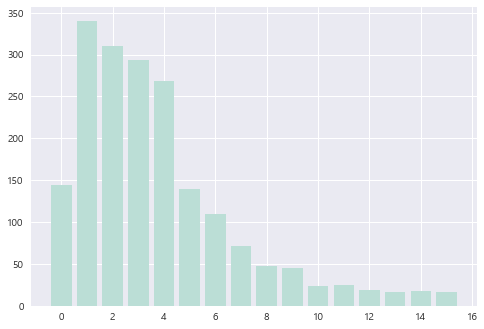

In [295]:
# Ham = df['Hammer_price_gr'].value_counts()
# 구간 값을 정확히 확인하기 위하여 15이하의 값 제거
Ham = df.query('Hammer_price_gr < 16')['Hammer_price_gr'].value_counts()
plt.bar(Ham.index,Ham, color=['#bbded6'])
plt.show()

#[해석] 솔직히 말하면 유의미한 결과는 아닌 것 같다
# 하지만 이젠 넘 지쳤어요